# IT Academy - Data Science with Python
## Sprint 12: Supervised Regressions
### [Github Supervised Regressions](https://github.com/jesussantana/Supervised-Regression)

[![forthebadge made-with-python](http://ForTheBadge.com/images/badges/made-with-python.svg)](https://www.python.org/)  
[![Made withJupyter](https://img.shields.io/badge/Made%20with-Jupyter-orange?style=for-the-badge&logo=Jupyter)](https://jupyter.org/try)  
[![wakatime](https://wakatime.com/badge/github/jesussantana/Supervised-Regression.svg)](https://wakatime.com/badge/github/jesussantana/Supervised-Regression)

In [1]:
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

plt.figure(figsize=(16, 6))
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='deep')

<Figure size 1152x432 with 0 Axes>

In [2]:
path = "../data/"
file = "processed/DelayedFlightsProcessed.csv"

In [3]:
df_raw = pd.read_csv(path + file)

### Exercise 1: 
  - Create at least three different regression models to try to best predict DelayedFlights.csv flight delay (ArrDelay).

### Exercise 2: 
  - Compare them based on MSE and R2.

### Exercise 3: 
  - Train them using the different parameters they support

### Exercise 4: 
  - Compare your performance using the traint / test approach or using all data (internal validation)

In [4]:
df = df_raw.copy()

In [5]:
df.head()

,ArrDelay,ArrTime,Distance,TaxiIn,TaxiOut,DayOfWeek,DepDelay,CarrierDelay,UniqueCarrier_9E,UniqueCarrier_AA,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,9.0,2104.0,737.0,3.0,9.0,4.0,22.0,16.72516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-3.0,1147.0,1438.0,18.0,13.0,4.0,7.0,16.72516,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,2118.0,1927.0,9.0,20.0,4.0,22.0,16.72516,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,2201.0,989.0,6.0,14.0,1.0,16.0,16.72516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.0,1329.0,1142.0,6.0,8.0,2.0,19.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
df.columns

Index(['ArrDelay', 'ArrTime', 'Distance', 'TaxiIn', 'TaxiOut', 'DayOfWeek',
       'DepDelay', 'CarrierDelay', 'UniqueCarrier_9E', 'UniqueCarrier_AA',
       'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO',
       'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9',
       'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_MQ',
       'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO',
       'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN',
       'UniqueCarrier_XE', 'UniqueCarrier_YV'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ArrDelay          1937 non-null   float64
 1   ArrTime           1937 non-null   float64
 2   Distance          1937 non-null   float64
 3   TaxiIn            1937 non-null   float64
 4   TaxiOut           1937 non-null   float64
 5   DayOfWeek         1937 non-null   float64
 6   DepDelay          1937 non-null   float64
 7   CarrierDelay      1937 non-null   float64
 8   UniqueCarrier_9E  1937 non-null   float64
 9   UniqueCarrier_AA  1937 non-null   float64
 10  UniqueCarrier_AS  1937 non-null   float64
 11  UniqueCarrier_B6  1937 non-null   float64
 12  UniqueCarrier_CO  1937 non-null   float64
 13  UniqueCarrier_DL  1937 non-null   float64
 14  UniqueCarrier_EV  1937 non-null   float64
 15  UniqueCarrier_F9  1937 non-null   float64
 16  UniqueCarrier_FL  1937 non-null   float64


In [8]:
df.head()

,ArrDelay,ArrTime,Distance,TaxiIn,TaxiOut,DayOfWeek,DepDelay,CarrierDelay,UniqueCarrier_9E,UniqueCarrier_AA,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,9.0,2104.0,737.0,3.0,9.0,4.0,22.0,16.72516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-3.0,1147.0,1438.0,18.0,13.0,4.0,7.0,16.72516,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,2118.0,1927.0,9.0,20.0,4.0,22.0,16.72516,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,2201.0,989.0,6.0,14.0,1.0,16.0,16.72516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.0,1329.0,1142.0,6.0,8.0,2.0,19.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
type(df)

pandas.core.frame.DataFrame

### Simple Linear Regression

In [10]:
# Matrix
X = df.iloc[:, 6].values.reshape((-1, 1))
# Vector
y = df.iloc[:, 0].values

- Divide the data set into training set and test set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

- Create Simple Linear Regression model with training set

In [12]:
from sklearn.linear_model import LinearRegression

regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

- Predict the test set

In [13]:
y_pred = regression.predict(X_test)

In [14]:
y_pred

array([  5.0935437 ,  91.8620894 ,  27.03501503,  24.04299621,
        14.06960015, 237.47367184,  12.07492094,  95.85144782,
         5.0935437 ,  28.03235463,   5.0935437 ,  10.08024173,
        14.06960015,   6.09088331,  34.01639227,  73.9099765 ,
        89.86741019,  19.05629818,   5.0935437 , 119.78759836,
         5.0935437 ,  15.06693976,   6.09088331, 102.83282506,
        25.04033581,  28.03235463,  74.9073161 ,  18.05895857,
        26.03767542,  27.03501503,  32.02171305,  10.08024173,
        36.01107148, 114.80090033,  59.94722202,  26.03767542,
        18.05895857,  25.04033581,   5.0935437 ,  27.03501503,
        25.04033581, 392.06131074,  67.92593886,   9.08290212,
        50.97116556,  17.06161897,  31.02437345,  38.00575069,
         5.0935437 ,  19.05629818,   7.08822291,  23.0456566 ,
         5.0935437 ,  49.97382596,  16.06427936,  14.06960015,
        74.9073161 ,   6.09088331,  35.01373187,   5.0935437 ,
        11.07758133,  65.93125965,  50.97116556,   9.08

- View training results

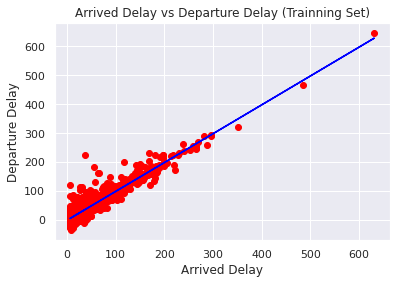

In [15]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, regression.predict(X_train), color = "blue")
plt.title("Arrived Delay vs Departure Delay (Trainning Set)")
plt.xlabel("Arrived Delay")
plt.ylabel("Departure Delay")
plt.show()

## Multiple Linear Regression

In [16]:
# Matrix
X = df.iloc[:, :-1].values
# Vector
y = df.iloc[:, 0].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [18]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = regression.predict(X_test)

- Build the optimal RLM model

In [20]:
import statsmodels.api as sm

In [21]:
X_opt = X[:, [1, 2, 3, 4, 5, 6]]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

X_opt = X[:, [1, 2, 3, 4, 5]]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

X_opt = X[:, [1, 2, 3, 4]]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

X_opt = X[:, [1, 2, 3]]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

X_opt = X[:, [1, 2]]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.327
Model:                            OLS   Adj. R-squared (uncentered):              0.326
Method:                 Least Squares   F-statistic:                              470.3
Date:                Thu, 06 May 2021   Prob (F-statistic):                   3.52e-167
Time:                        16:57:57   Log-Likelihood:                         -10501.
No. Observations:                1937   AIC:                                  2.101e+04
Df Residuals:                    1935   BIC:                                  2.102e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0182      0.001     16.223      0.000       0.016       0.020
x2             0.0095      0.002      4.699      0.000       0.006       0.013
==============================================================================
Omnibus:                     1192.170   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15938.621
Skew:                           2.681   Prob(JB):                         0.00
Kurtosis:                      15.990   Cond. No.                         3.30
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Build the optimal RLM model using Automatic Backward Elimination

In [22]:
def backwardElimination(x, sl):    
    numVars = len(x[0])    
    for i in range(0, numVars):        
        regressor_OLS = sm.OLS(y, x.tolist()).fit()        
        maxVar = max(regressor_OLS.pvalues).astype(float)        
        if maxVar > sl:            
            for j in range(0, numVars - i):                
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):                    
                    x = np.delete(x, j, 1)    
        
    return regressor_OLS.summary()
 
SL = 0.05
X_opt = X[:, [1, 2, 3, 4, 5, 6]]
X_Modeled = backwardElimination(X_opt, SL)

In [23]:
X_Modeled

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          1.016e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):                        0.00
Time:                        16:57:58   Log-Likelihood:                         -7511.0
No. Observations:                1937   AIC:                                  1.503e+04
Df Residuals:                    1931   BIC:                                  1.507e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0056      0.000    -15.468      0.000      -0.006      -0.005
x2            -0.0062      0.000    -13.697      0.000      -0.007      -0.005
x3             0.7002      0.050     13.921      0.000       0.602       0.799
x4             0.7935      0.019     42.641      0.000       0.757       0.830
x5            -0.9900      0.116     -8.557      0.000      -1.217      -0.763
x6             0.9664      0.005    183.056      0.000       0.956       0.977
==============================================================================
Omnibus:                      196.719   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              606.337
Skew:                           0.514   Prob(JB):                    2.17e-132
Kurtosis:                       5.541   Cond. No.                         811.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Polynomial Regression

In [24]:
df.head()

,ArrDelay,ArrTime,Distance,TaxiIn,TaxiOut,DayOfWeek,DepDelay,CarrierDelay,UniqueCarrier_9E,UniqueCarrier_AA,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,9.0,2104.0,737.0,3.0,9.0,4.0,22.0,16.72516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-3.0,1147.0,1438.0,18.0,13.0,4.0,7.0,16.72516,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,2118.0,1927.0,9.0,20.0,4.0,22.0,16.72516,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,2201.0,989.0,6.0,14.0,1.0,16.0,16.72516,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.0,1329.0,1142.0,6.0,8.0,2.0,19.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
# Matrix
X = df.iloc[:, 1:2].values

# Vector
y = df.iloc[:, 0:1].values


In [26]:
X.shape
y.shape

(1937, 1)

- Fit Polynomial regression with the dataset

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y)

LinearRegression()

## Visualization of the results of the Polynomial Model vs Linear Regression

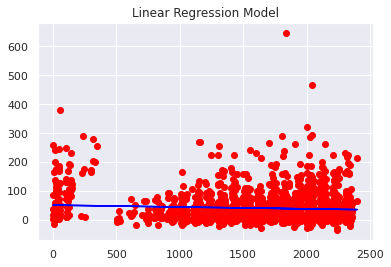

In [29]:
plt.scatter(X, y, color = "red")
plt.plot(X, lin_reg.predict(X), color = "blue")
plt.title("Linear Regression Model")
plt.xlabel("")
plt.ylabel("")
plt.show()

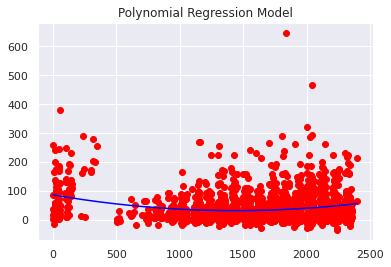

In [30]:
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape(len(X_grid), 1)

plt.scatter(X, y, color = "red")
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = "blue")
plt.title("Polynomial Regression Model")
plt.xlabel("")
plt.ylabel("")
plt.show()